<a href="https://www.kaggle.com/code/siennasimms/spectral-classification-of-stars?scriptVersionId=160442257" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skyserver-stellar-spectrography/Stellar Dataset - Skyserver_Spectro1_12_2024 3_14_39 PM.csv


/tmp/ipykernel_17/2848793772.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
dataframe = pd.read_csv('/kaggle/input/skyserver-stellar-spectrography/Stellar Dataset - Skyserver_Spectro1_12_2024 3_14_39 PM.csv')

# Maps spectral class to numerical values
spectral = {'O':0, 'B':10, 'A':20, 'F':30, 'G':40, 'K':50, 'M':60, 'C':70, 'WD':80}

# Converts the class into a numerical value (81 possible numbers)
def subclass_to_number(c):
    if c == 'WD':
        return 80
    elif (len(c) == 2) and c[1].isnumeric():
        return spectral[c[0]] + int(c[1])
    else:
        return np.NaN

dataframe['subClass'] = \
    dataframe['subClass'].map(subclass_to_number)

df = dataframe.dropna() # Drops unaccounted for classifications

print(df.shape)
df.head()

(987, 9)


,ra,dec,bestObjID,subClass,deVMag_g,deVMag_i,deVMag_r,deVMag_u,deVMag_z
0,319.58935,0.165350,1237663457777549712,40.0,18.79706,18.16984,18.33882,19.89120,18.08014
1,320.33321,0.988105,1237678617937314406,64.0,18.03522,14.97137,16.52078,20.51621,14.08766
2,319.94081,0.425954,1237663458314551815,60.0,18.34934,16.20832,16.95681,20.77544,15.75679
3,320.42819,1.110898,1237678617937379974,62.0,19.74458,17.51637,18.40552,21.52722,16.97464
4,142.72133,19.408384,1237667542287515661,20.0,16.29160,16.26964,16.25856,17.40467,16.29506


In [3]:
# Splits into the training and validation datasets
val_df = df.sample(frac=0.2, random_state=1337)
train_df = df.drop(val_df.index)

print(
    f"Using {len(train_df)} samples for training "
    f"and {len(val_df)} for validation"
)

Using 790 samples for training and 197 for validation


In [4]:
# Splits datasets into the features(X) and classification (y)
features = ['deVMag_g', 'deVMag_i', 'deVMag_r', 'deVMag_u', 'deVMag_z']
X_val = val_df[features]
y_val = val_df['subClass']
X_train = train_df[features]
y_train = train_df['subClass']

input_shape = [X_train.shape[1]]

Epoch 1/100
7/7 [==============================] - 2s 61ms/step - loss: 4.4114 - accuracy: 0.1316 - val_loss: 7.5022 - val_accuracy: 0.0254
Epoch 2/100
7/7 [==============================] - 0s 13ms/step - loss: 3.0381 - accuracy: 0.3392 - val_loss: 8.8010 - val_accuracy: 0.0254
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 2.4808 - accuracy: 0.4127 - val_loss: 8.8922 - val_accuracy: 0.0254
Epoch 4/100
7/7 [==============================] - 0s 13ms/step - loss: 2.1507 - accuracy: 0.4696 - val_loss: 7.8420 - val_accuracy: 0.0203
Epoch 5/100
7/7 [==============================] - 0s 14ms/step - loss: 1.8536 - accuracy: 0.4722 - val_loss: 7.1030 - val_accuracy: 0.0203
Epoch 6/100
7/7 [==============================] - 0s 11ms/step - loss: 1.7434 - accuracy: 0.5228 - val_loss: 6.2982 - val_accuracy: 0.0203
Epoch 7/100
7/7 [==============================] - 0s 14ms/step - loss: 1.6841 - accuracy: 0.5000 - val_loss: 5.7244 - val_accuracy: 0.0203
Epoch 8/100
7/7 [===

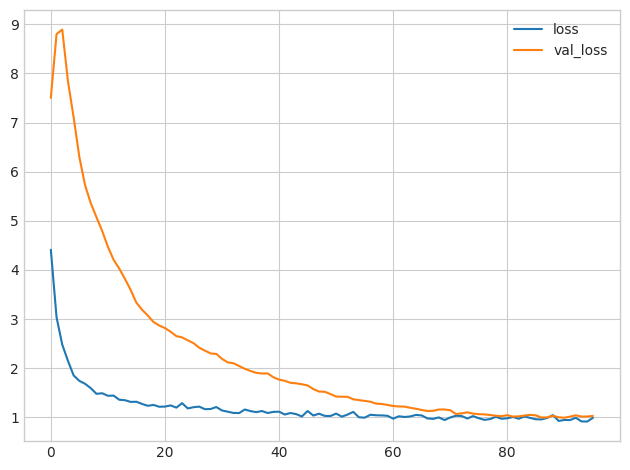

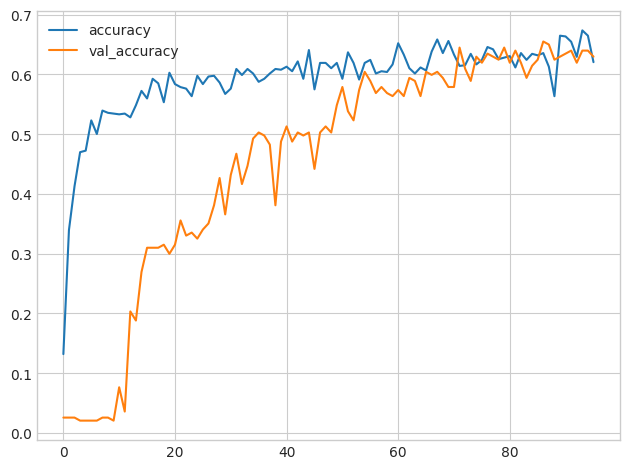

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

# Model
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256, input_dim=5, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(81, activation='softmax') # For multiple outputs
])

model.compile(
    loss='SparseCategoricalCrossentropy', # For categorical classification models
    optimizer='adam', 
    metrics=['accuracy']
)
early_stopping = keras.callbacks.EarlyStopping( # prevents overfitting
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=128,
    epochs=100,
    callbacks=[early_stopping]
)

# Performance statistics
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))
print("Maximum Accuracy: {:0.4f}".format(history_df['val_accuracy'].max()))

7/7 [==============================] - 0s 2ms/step
Overall Accuracy: 0.6345


Text(9.444444444444448, 0.5, 'Subclass')

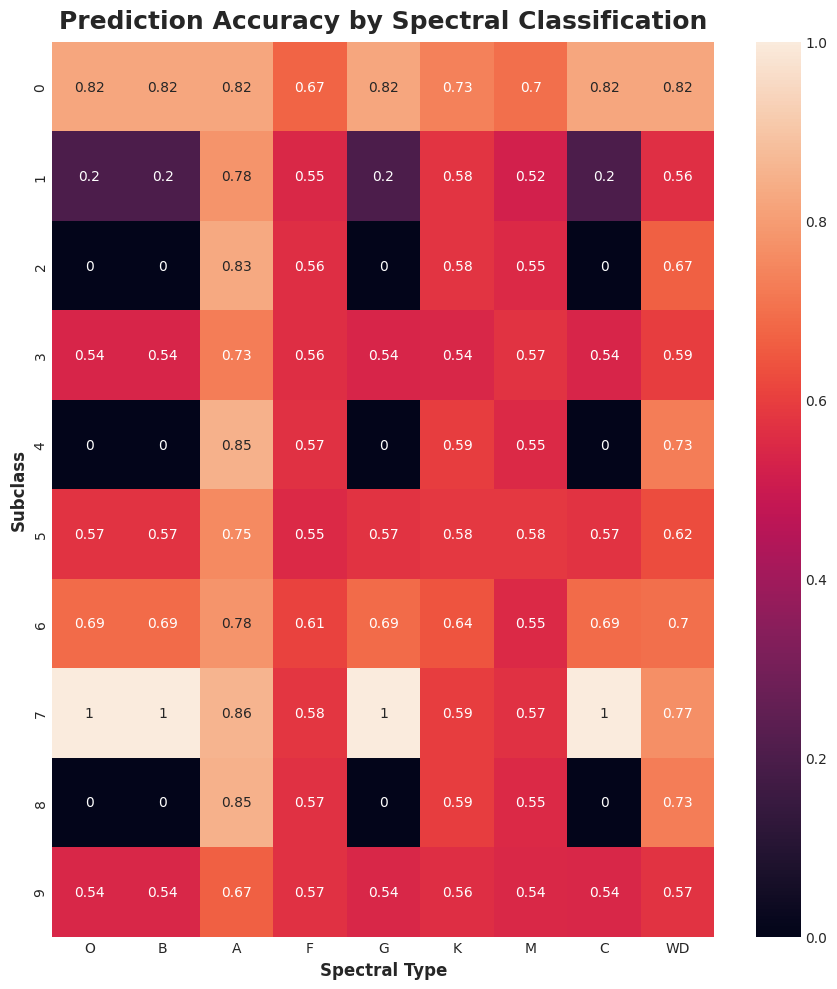

In [6]:
import seaborn as sns

# Transposed dictionary mapping numbers to spectral class
spectral_T = {key: value for (value, key) in spectral.items()}

# Model predictions from validation inputs
y_pred = model.predict(X_val)

# Returns array of numerical categories from 2D array of probabilities
def prediction_category(y):
    y_cat = np.zeros(len(y))
    for i in range(len(y)):
        max_prob = np.max(y[i])
        category = np.where(y[i] == max_prob)[0][0] # Index with the highest probability
        y_cat[i] = category
    return y_cat

# Returns 9x10 array of accuracies by category
# 9 = # spectral classes  and 10 = # spectral subclasses
def precent_predicted_by_class(y_class, y_sub, matches):
    percentages = np.zeros([9, 10])
    for c in spectral.keys():
        class_indices = np.where(y_class != c)[0]
        for i in range(10):
            sub_indices = np.where(y_sub != i)[0]
            indices = np.intersect1d(class_indices, sub_indices) # Indices not included in the category
            match_vals = np.delete(matches, indices)
            if len(match_vals) != 0: # 0.0 accuracy if there is not data
                percentages[spectral[c]//10][i] = np.mean(match_vals)
    return percentages
            

y_pred = prediction_category(y_pred)

# Maps array of numerical categories to the corresponding spectral class
y_pred_class = np.array(list(map(lambda y : spectral_T[y//10 * 10], y_pred)))

# Maps array of numerical categories to the corresponding spectral subclass
y_pred_sub = np.array(list(map(lambda y: y%10, y_pred)))

# Boolean array for y_val == y_pred
matches = np.equal(y_val.values.tolist(), y_pred)

print("Overall Accuracy: {:0.4f}".format(np.mean(matches)))
percentages = precent_predicted_by_class(y_pred_class, y_pred_sub, matches)

# Dataframe of accuracies 
# columns = spectral class and rows = spectral subclass
categorical_accuracy = {"O": percentages[0],
                       "B" : percentages[1],
                       "A" : percentages[2],
                       "F" : percentages[3],
                       "G" : percentages[4],
                       "K" : percentages[5],
                       "M" : percentages[6],
                       "C" : percentages[7],
                       "WD" : percentages[8]}
df_categorical_accuracy = pd.DataFrame(categorical_accuracy)

# Heat map of accuracies by spectral classification
plt.figure(figsize=(9,10))
plt.title("Prediction Accuracy by Spectral Classification")
sns.heatmap(data=df_categorical_accuracy, annot=True)
plt.xlabel("Spectral Type")
plt.ylabel("Subclass")
